In [2]:
import os, copy, h5py
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import numpy as np
import pandas as pd
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir
from compas_python_utils.cosmic_integration.ClassCOMPAS import COMPASData
from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023, madau_dickinson_sfr
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022, compas_log_skew_normal_distribution_metallicity_distribution
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.cosmology_utils import lookback_time_to_redshift
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict
import matplotlib.pyplot as plt
from population_vis import get_formation_efficiency
import time
import warnings
import scipy

Let's try and plot the SFRD ourselves, since something is just not going right. From Neijssel we have:
$$\frac{dP}{dZ}(z)=\frac{1}{Z\sigma\sqrt{2\pi}}e^{-\frac{(\ln Z-\mu(z))^2}{2\sigma^2}}$$
Inferring from Langer Norman 2007 and also the code from SSPC, the mean metallicity distribution follows a power law:
$$\mu(z)=\mu_0\times10^{\mu_z\times z}$$

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_35154/1518145524.py:8: RuntimeWarning: divide by zero encountered in power
  prefactor = np.power(Zi, -1)*(1/(sigma*np.sqrt(2*np.pi)))
/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_35154/1518145524.py:9: RuntimeWarning: divide by zero encountered in log
  return prefactor*np.exp(-np.power(np.log(Zi)-mu(z), 2)/(2*sigma**2))
/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_35154/1518145524.py:9: RuntimeWarning: invalid value encountered in multiply
  return prefactor*np.exp(-np.power(np.log(Zi)-mu(z), 2)/(2*sigma**2))
/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_35154/1518145524.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


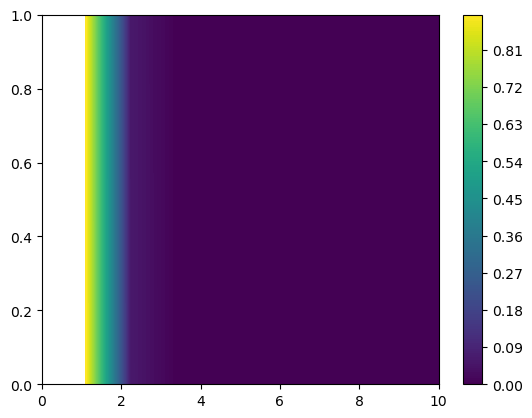

In [3]:
# now we want to plot this function in 3d
def mu(z, mu0=0.012, muz=-0.15):
    return mu0*np.power(10, muz*z)

def dpdZ(z, Zi, sigma0=1.125, sigmaz=0.048):
    # sigma = sigma0*np.power(10, z*sigmaz)
    sigma = 0.39
    prefactor = np.power(Zi, -1)*(1/(sigma*np.sqrt(2*np.pi)))
    return prefactor*np.exp(-np.power(np.log(Zi)-mu(z), 2)/(2*sigma**2))

def dpdLogZ(z, Z):
    sigma = 0.39
    prefactor = np.power(np.exp(np.e, Z), -1)*(1/(sigma*np.sqrt(2*np.pi)))
    return prefactor*np.exp(-np.power(Z-mu(z), 2)/(2*sigma**2))

# print(dpdZ(np.random.rand(100), np.random.rand(100)))

fig, ax = plt.subplots(1,1)
Zgrid, zgrid = np.meshgrid(
    np.linspace(0, 10, 10),
    np.linspace(10e-20, 10e-1, 10),
)
cm = ax.contourf(Zgrid, zgrid, dpdZ(zgrid, Zgrid), levels=200)
fig.colorbar(cm)
# ax.set_yscale('log')
# ax.set_xscale('log')
fig.show()

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_35154/2144994286.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


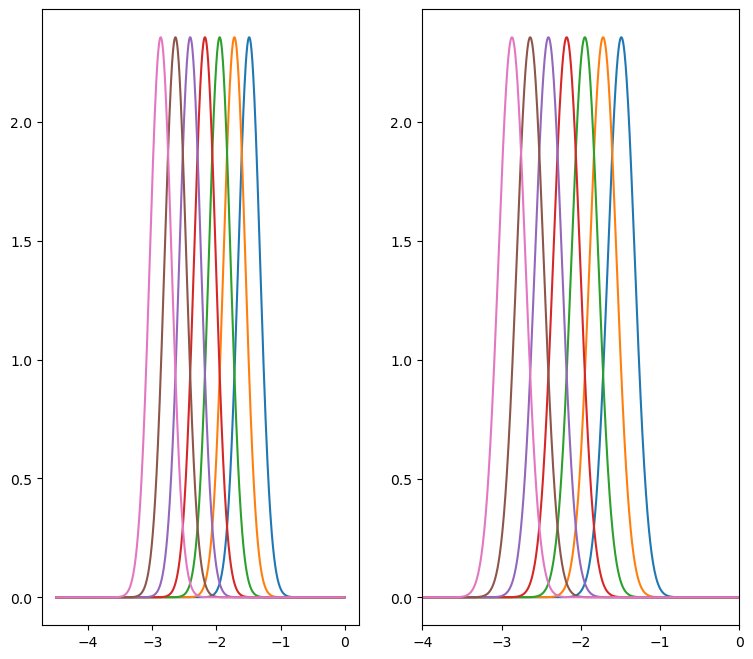

In [33]:
# maybe copy from Floor's code

def returnFractionLogNormal(Zlower, Zupper, redshift):
    """
    Instead of combining a GSMF and MZ relation
    you can also directly construct a redshift dependent metallicity distribution

    In this case we focus on a log-normal distribution

    log10(Z) is normally distributed with:

    meanM  = log(Zmean)
                This is redshift dependent and Zmean scales as
                Zmean = Z0 * 10^(alpha * redshift)
                Z0 is the mean metallicity at redshift zero
                alpha is the scaling of the redshift

    sigma  = the standard deviation of log(Z) distribution
                we assume for now that this is redshift independent

    """
    Z0       = 0.035
    alpha    = -0.23
    sigma    = 0.39

    Zmean    = Z0 * (10**(alpha*redshift))
    mu       = np.log(Zmean)  - (sigma * sigma) /2.
    Xupper   = (np.log(Zupper) - mu)/float(np.sqrt(2)*sigma)
    CDFUpper = 0.5 + 0.5 * scipy.special.erf(Xupper)
    Xlower   = (np.log(Zlower) - mu)/float(np.sqrt(2)*sigma)
    CDFLower =  0.5 + 0.5 * scipy.special.erf(Xlower)
    fraction = CDFUpper - CDFLower 
    return fraction

def fractionLogNormalCenter(Z_center, redshift_center, width, diff):
    # diff = 0.045
    return returnFractionLogNormal(
        Z_center - diff/2,
        Z_center + diff/2,
        redshift_center
    )/width

fig, (axes, comp_ax) = plt.subplots(1,2, figsize=(9,8))
# set metallicity range
zBins = np.logspace(-4.5,0.,1000)
center = (zBins[1:] + zBins[:-1])/2.
width  = np.diff(np.log10(zBins))
# print(width)
redshifts = [0, 1, 2, 3, 4, 5, 6]

for nrz, redshift in enumerate(redshifts):
    PDF = np.zeros(len(center))
    for nrZ, Z in enumerate(center):
        Zlower   = zBins[nrZ]
        Zupper   = zBins[nrZ+1]
        PDF[nrZ] = returnFractionLogNormal(Zlower, Zupper, redshift)
    PDF = np.divide(PDF, width)

    # assert np.sum(np.isclose(PDF, fractionLogNormalCenter(center, redshift)))==0
    # print(f'should be: {PDF} and is: {fractionLogNormalCenter(center, redshift)}')
    axes.plot(np.log10(center), PDF)
    comp_ax.plot(np.log10(center), fractionLogNormalCenter(center, redshift, 0.0045, np.diff(zBins)))

comp_ax.set_xlim(-4, 0)
fig.show()

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_35154/764347179.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  twodfig.show()


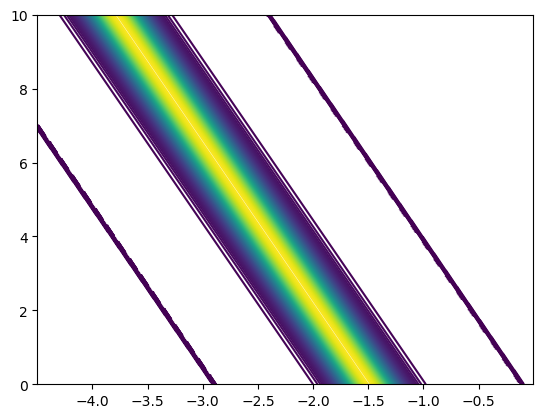

In [40]:
# ok now let's do this in 2D. if we can marginalize this correctly then we've done something right
Zmesh, redshiftMesh = np.meshgrid(
    center,
    np.linspace(0, 10, 1000)
)
func = fractionLogNormalCenter(Zmesh, redshiftMesh, 0.0045, np.diff(zBins))
twodfig, twodax = plt.subplots(1,1)
twodax.contour(np.log10(Zmesh), redshiftMesh, func, levels=100)
twodfig.show()